# 05c parameter optimisation 

In [1]:
#|default_exp core.05c_parameter_optimisation

In [2]:
import autograd.numpy as np
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize
import pandas as pd
from matplotlib import pyplot as plt

from dementia_inequalities import const, log, utils, tools 

---

In [3]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.001420
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.002790
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.001299
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.004970
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.001138


In [4]:
# The real dementia x and y data 

# covariates 
covar = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']
x = df_dem_plus[covar].values.reshape(-1,7)
#covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)

# Outcome data 
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

In [5]:
def shift_log_normal_pdf(x, delta, mu, sigma):
    if isinstance(delta, int) or isinstance(delta, float):
        delta = delta * np.ones(len(x)).T
    else:
        delta = delta.T
    mu = mu * np.ones(len(x)).T
    x_shift = np.subtract(x.squeeze(), delta.squeeze())
    norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
    exp_part = np.exp(-(1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift.squeeze(), mu.squeeze())) ** 2))
    return norm_const * exp_part

# Define the negative log-likelihood function for optimisation
def neg_loglike(params):
    beta_0 = params[0]
    beta = params[1:-2]
    mu = params[-2]
    sigma = params[-1]
    y_pred = np.dot(x, beta) + beta_0
    likelihood = shift_log_normal_pdf(y, delta=y_pred, mu=mu, sigma=sigma)
    log_likelihood = np.nan_to_num(np.log(likelihood))
    return -np.sum(log_likelihood)

In [6]:
def log_norm_mode(mu:int, # mean of the variables log
                  sigma:int): # standard deviation of the variables log
    return np.exp(mu - sigma**2)

In [7]:
n_features = 7

np.random.seed(27)
initial_params = np.concatenate([np.random.normal(size=n_features+1), [0, 0.25]]) 

In [8]:
# def f(xy):
#     x, y = xy
#     return -(x**2 + y**2)  # Negate because we are actually maximizing

# Gradient of the function
grad_loglike = grad(neg_loglike)

# Initial guess
x0 = initial_params

# Use scipy's minimize function with the BFGS algorithm
result = minimize(neg_loglike, x0, method = 'BFGS')

result

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.0
        x: [ 1.286e+00 -3.036e-01  6.191e-01  3.960e-01  2.234e-01
            -5.434e-02 -1.793e-01  2.428e-01  0.000e+00  2.500e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 11
     njev: 1

In [9]:
# # derivates of neg_loglike
# jacobian_  = jacobian(neg_loglike)

# result2 = minimize(neg_loglike, x0, method = 'BFGS', \
#                options={'disp': False}, jac = jacobian_)

# result2

In [10]:
# Extract the MAP from the parameter samples
MAP_params = result.x

MAP_beta = MAP_params[:-2]
MAP_mu = MAP_params[-2]
MAP_sigma = MAP_params[-1]

print("MAP estimates \n--------------\n--------------")
print(f'Intercept:{MAP_beta[0]}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MAP_beta[i+1]}')
print("--------------\nLog normal coefficients\n--------------")
print("Mu:", MAP_mu)
print("Sigma:", MAP_sigma)

MAP estimates 
--------------
--------------
Intercept:1.2856054152322811
--------------
Regression coefficients
--------------
over_65_pc:-0.30355337730615073
female_pc:0.6190756618694475
ALevel_plus_pc:0.39599854914377247
white_pc:0.22340564775539556
HYP_afflicted_pc:-0.05433941722861124
DM_afflicted_pc:-0.17927632611276223
STIA_afflicted_pc:0.24283197254142283
--------------
Log normal coefficients
--------------
Mu: 0.0
Sigma: 0.25


/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_12222/3355181439.py:8: RuntimeWarning: divide by zero encountered in divide
  norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_12222/3355181439.py:10: RuntimeWarning: invalid value encountered in multiply
  return norm_const * exp_part


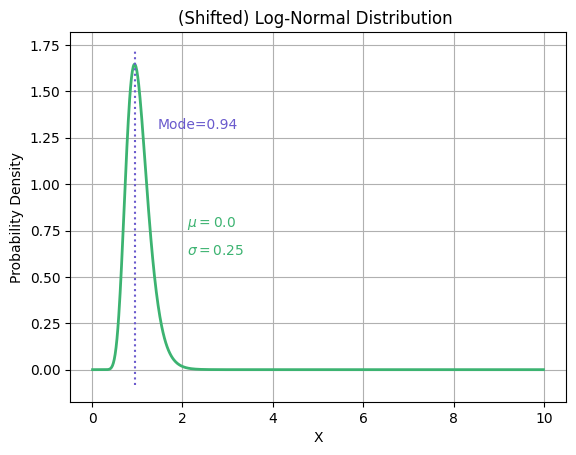

In [11]:
# mode of the log normal 
mode = log_norm_mode(MAP_mu, MAP_sigma)

# plot log normal of MAp parameters 
x = np.arange(0, 10, 0.01)
pdf_x_mu0 = shift_log_normal_pdf(x, 0, MAP_mu, MAP_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen')
plt.text(2.1, 0.62, f'$\sigma=${MAP_sigma}', color='mediumseagreen')
plt.text(2.1, 0.77, f'$\mu=${MAP_mu}', color='mediumseagreen')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

ymin, ymax = plt.ylim()
plt.vlines(mode, ymin, ymax, color='slateblue', label='Log normal mode', linestyles='dotted')
plt.text(mode+0.5, 3*ymax/4, f'Mode={np.round(mode,2)}', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()